<h1 style="color:#4169e1; font-size:28px;"><b>Olivetti Faces Recognition using PCA-SVM with RBF kernel</b></h1>

<h2 style="color:#9932cc; font-size:20px;"><b>Import Libraries and Setup</b></h2>

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')

<h2 style="color:#9932cc; font-size:20px;"><b>Define Face Recognizer Class</b></h2>

In [124]:
class FaceRecognizer:

    def __init__(self, n_components=0.95, random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.scaler = None
        self.pca = None
        self.svm = None
        
    def load_data(self):
        print("Loading Olivetti faces dataset...")
        faces = fetch_olivetti_faces(shuffle=True, random_state=self.random_state)
        
        print(f"Dataset shape: {faces.data.shape}")
        print(f"Number of classes: {len(np.unique(faces.target))}")
        print(f"Samples per class: {len(faces.target) // len(np.unique(faces.target))}")
        
        return faces.data, faces.target
    
    def split_data(self, X, y, test_size=0.25):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=self.random_state
        )
        
        print(f"\nData split:")
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        return X_train, X_test, y_train, y_test
    
    def preprocess_data(self, X_train, X_test):
        print("\nPreprocessing data...")
        
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled
    
    def apply_pca(self, X_train, X_test):
        print(f"\nApplying PCA with {self.n_components} components/variance...")
        
        self.pca = PCA(n_components=self.n_components, random_state=self.random_state)
        X_train_pca = self.pca.fit_transform(X_train)
        X_test_pca = self.pca.transform(X_test)
        
        print(f"Original dimensions: {X_train.shape[1]}")
        print(f"Reduced dimensions: {X_train_pca.shape[1]}")
        print(f"Explained variance ratio: {self.pca.explained_variance_ratio_.sum():.4f}")
        
        return X_train_pca, X_test_pca
    
    def train_svm(self, X_train, y_train):
        print("\nTraining SVM with hyperparameter tuning...")
        
        param_grid = {
            'C': [1, 10, 100],
            'gamma': ['scale', 0.001, 0.01]
        }
        
        svm = SVC(kernel='rbf', random_state=self.random_state)
        
        grid_search = GridSearchCV(
            svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        self.svm = grid_search.best_estimator_
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
        
        return self.svm
    
    def evaluate_model(self, X_test, y_test):
        print("\nEvaluating model...")
        
        y_pred = self.svm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Test Accuracy: {accuracy:.4f}")
        print("\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred))
        
        return y_pred, accuracy
    
    def plot_results(self, y_test, y_pred):
        # Create first figure for confusion matrix (larger size)
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
        ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Actual', fontsize=12)
        
        # Add colorbar
        plt.colorbar(im, ax=ax)
        
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center", fontsize=8,
                       color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.show()
        
        # Create second figure for variance plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Cumulative Explained Variance
        cumvar = np.cumsum(self.pca.explained_variance_ratio_)
        ax.plot(range(1, len(cumvar) + 1), cumvar, 'bo-', linewidth=2, markersize=4)
        ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
        ax.set_title('Cumulative Explained Variance', fontsize=16, fontweight='bold')
        ax.set_xlabel('Number of Components', fontsize=12)
        ax.set_ylabel('Cumulative Variance', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create separate figure for eigenfaces with larger size and no gaps
        eigenfaces = self.pca.components_[:9]
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        fig.suptitle('Top 9 Eigenfaces', fontsize=16, fontweight='bold')
        
        for i in range(9):
            row, col = i // 3, i % 3
            eigenface = eigenfaces[i].reshape(64, 64)
            axes[row, col].imshow(eigenface, cmap='gray')
            axes[row, col].set_title(f'PC {i+1}', fontsize=12)
            axes[row, col].axis('off')
        
        # Remove gaps between subplots
        plt.subplots_adjust(hspace=0.1, wspace=0.1)
        plt.show()


<h2 style="color:#9932cc; font-size:20px;"><b>Initialize and Load Dataset</b></h2>

In [125]:
recognizer = FaceRecognizer(
    n_components=0.95,
    random_state=42
)

print(f"PCA components: {recognizer.n_components}")
print(f"Random state: {recognizer.random_state}")

# Load the dataset
print("\n" + "="*50)
X, y = recognizer.load_data()
print("="*50)

PCA components: 0.95
Random state: 42

Loading Olivetti faces dataset...
Dataset shape: (400, 4096)
Number of classes: 40
Samples per class: 10


<h2 style="color:#9932cc; font-size:20px;"><b>Visualize Sample Faces</b></h2>

Sample faces from the dataset:


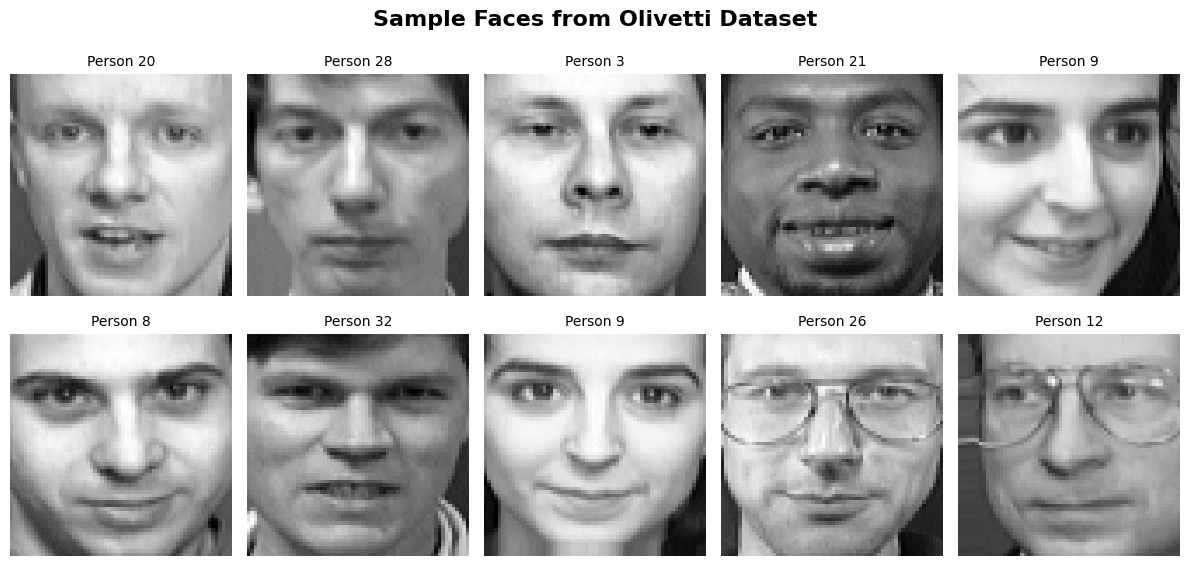

Displayed 10 sample faces
Each face is 64x64 pixels = 4096 features


In [126]:
print("Sample faces from the dataset:")

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row, col = i // 5, i % 5
    face = X[i].reshape(64, 64)
    axes[row, col].imshow(face, cmap='gray')
    axes[row, col].set_title(f'Person {y[i]}', fontsize=10)
    axes[row, col].axis('off')

plt.suptitle('Sample Faces from Olivetti Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Displayed 10 sample faces")
print(f"Each face is 64x64 pixels = {64*64} features")

<h2 style="color:#9932cc; font-size:20px;"><b>Split Data</b></h2>

In [127]:
X_train, X_test, y_train, y_test = recognizer.split_data(X, y)
print(f"Train/Test ratio: {len(X_train)/(len(X_train)+len(X_test)):.2%}/{len(X_test)/(len(X_train)+len(X_test)):.2%}")


Data split:
Training set: 300 samples
Test set: 100 samples
Train/Test ratio: 75.00%/25.00%


<h2 style="color:#9932cc; font-size:20px;"><b>Preprocess Data</b></h2>

In [128]:
X_train_scaled, X_test_scaled = recognizer.preprocess_data(X_train, X_test)
print(f"Data mean (before): {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"Data mean (after): {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")


Preprocessing data...
Data mean (before): 0.5484, std: 0.1724
Data mean (after): 0.0000, std: 1.0000


<h2 style="color:#9932cc; font-size:20px;"><b>Apply Principal Component Analysis(PCA)</b></h2>

In [129]:
X_train_pca, X_test_pca = recognizer.apply_pca(X_train_scaled, X_test_scaled)
print(f"Dimensionality reduction: {X_train.shape[1]} → {X_train_pca.shape[1]} features")
print(f"Compression ratio: {X_train_pca.shape[1]/X_train.shape[1]*100:.1f}%")


Applying PCA with 0.95 components/variance...
Original dimensions: 4096
Reduced dimensions: 108
Explained variance ratio: 0.9503
Dimensionality reduction: 4096 → 108 features
Compression ratio: 2.6%


<h2 style="color:#9932cc; font-size:20px;"><b>Train SVM Model</b></h2>

In [130]:
svm_model = recognizer.train_svm(X_train_pca, y_train)


Training SVM with hyperparameter tuning...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'C': 10, 'gamma': 'scale'}
Best cross-validation score: 0.9333


<h2 style="color:#9932cc; font-size:20px;"><b>Evaluate Model</b></h2>

In [131]:
y_pred, accuracy = recognizer.evaluate_model(X_test_pca, y_test)
print(f"Final Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Evaluating model...
Test Accuracy: 0.9600

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
     

<h2 style="color:#9932cc; font-size:20px;"><b>Visualize Results</b></h2>

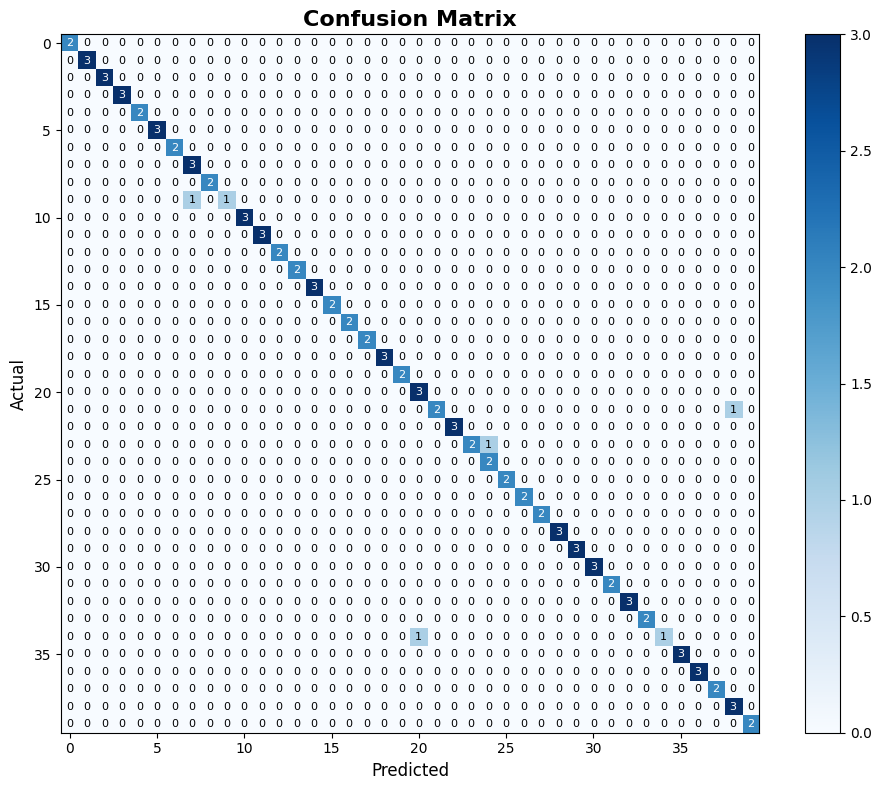

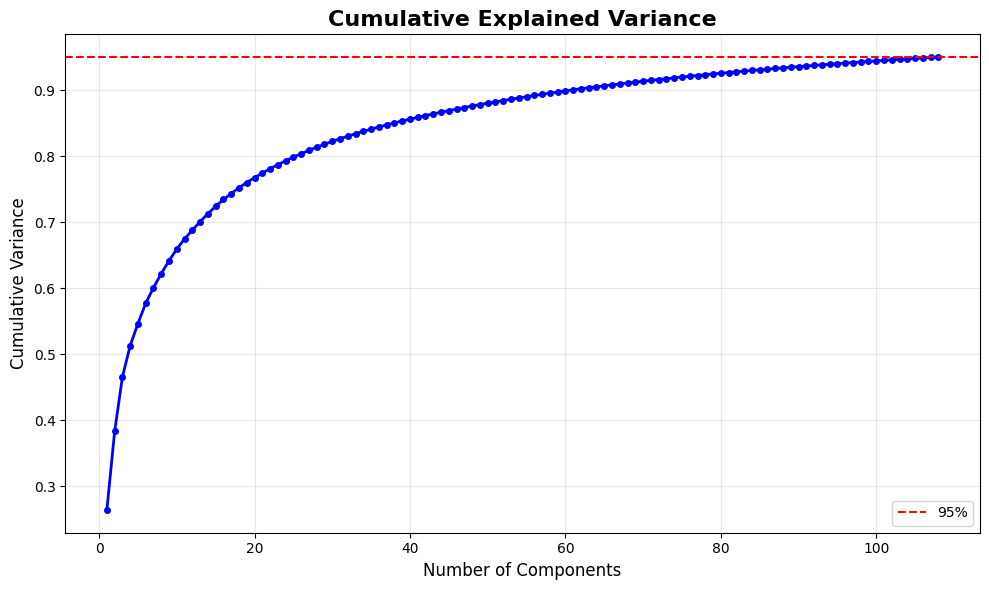

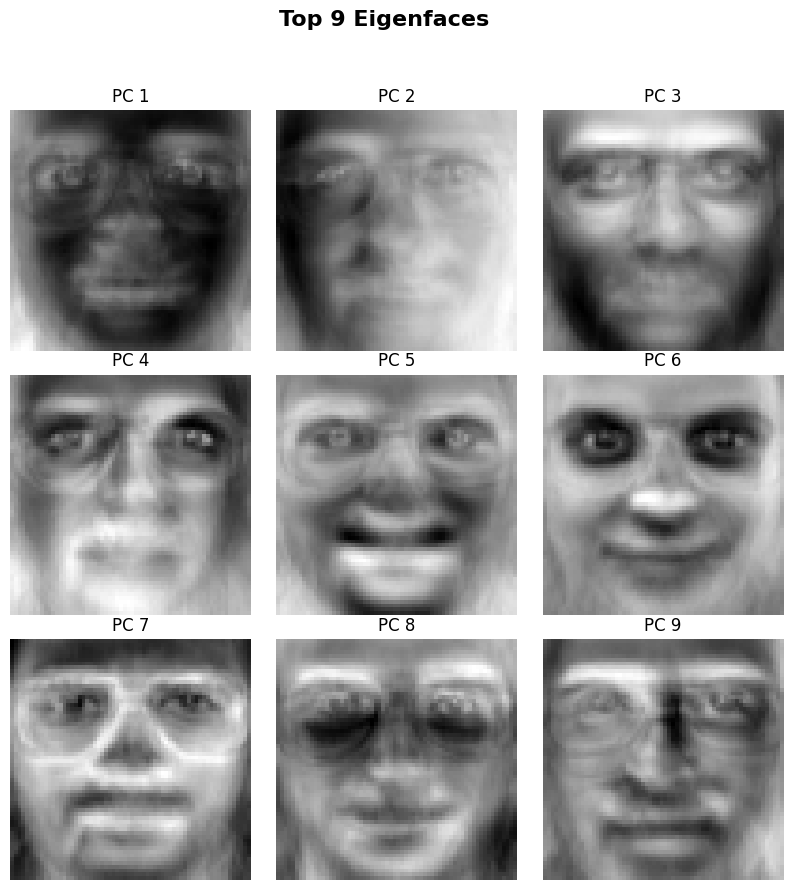

In [132]:
recognizer.plot_results(y_test, y_pred)

<h2 style="color:#9932cc; font-size:20px;"><b>Performance Summary</b></h2>

In [133]:
print("FINAL RESULTS")
print("=" * 60)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"PCA Components Used: {X_train_pca.shape[1]}")
print(f"Dimensionality Reduction: {X_train.shape[1]} → {X_train_pca.shape[1]} features")
print(f"Variance Retained: {recognizer.pca.explained_variance_ratio_.sum():.4f} ({recognizer.pca.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"Total Features Reduced by: {(1-X_train_pca.shape[1]/X_train.shape[1])*100:.1f}%")

print("\n" + "=" * 60)

final_results = {
    'accuracy': accuracy,
    'pca_components': X_train_pca.shape[1],
    'original_features': X_train.shape[1],
    'variance_retained': recognizer.pca.explained_variance_ratio_.sum(),
    'dimensionality_reduction': (1-X_train_pca.shape[1]/X_train.shape[1])*100
}

final_results

FINAL RESULTS
Test Accuracy: 0.9600 (96.00%)
PCA Components Used: 108
Dimensionality Reduction: 4096 → 108 features
Variance Retained: 0.9503 (95.03%)
Total Features Reduced by: 97.4%



{'accuracy': 0.96,
 'pca_components': 108,
 'original_features': 4096,
 'variance_retained': 0.950293,
 'dimensionality_reduction': 97.36328125}